In [1]:
import math
import random
import torch
import numpy as np
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import copy
import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import torch.distributions as D
import torch.nn.functional as F
from scipy.interpolate import griddata

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
print(dev)

cuda:0


D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# global veriable
Uniform_low_bound = 0
Uniform_up_bound = 1
Agent_number_n = 3
number_of_groups = 2
Normal_loc = 0.5
Normal_scale = 0.2
Normal_loc1 = 0
Normal_loc2 = 1.5
Normal_scale1 = 0.2
Normal_scale2 = 0.2
Distribution_number = 5000

beta_a = 0.3
beta_b = 0.2
cauchyloc = 1.0/Agent_number_n
cauchyscalen = 0.004
kumaraswamy_a = beta_a
kumaraswamy_b = (1.0 + (beta_a - 1.0) * math.pow(
    (beta_a + beta_b - 2.0) / (beta_a - 1.0), beta_a)) / beta_a
print(kumaraswamy_b)

independentnormalloc1 = [(float(ii) + 1) / (2 * Agent_number_n + 1)
                         for ii in range(Agent_number_n, 0, -1)]
independentnormalscale1 = [0.05 for ii in range(Agent_number_n)]

independentnormalloc2 = [(float(ii) + 1) / (2 * Agent_number_n + 1)
                         for ii in range(1, Agent_number_n + 1, 1)]
independentnormalscale2 = [0.05 for ii in range(Agent_number_n)]
exponentialhigh = 15  #Symbol("b", real=True)
exponentiallow = 15  #Symbol("a", real=True)

target = "min_sum" 
#target = "min_max"
order = "twopeaknormal"
# "twopeak","normal","uniform","independent1","independent2","cauchy","beta","U-exponential","arcsine"
order1name = ["dp", "random initializing", "costsharing", "heuristic"]
# "costsharing","dp","heuristic","random initializing"

0.40058530825361593


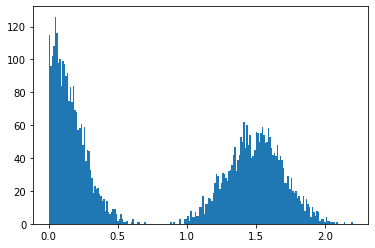

2500
[[1.47149399e+00 1.22505814e+00 1.67763828e+00]
 [2.83883319e-02 1.51454800e+00 1.44542556e+00]
 [6.97711953e-03 1.66260527e+00 1.40815879e-03]]
2500


In [3]:
seed = 7
np.random.seed(seed)
# exec(open('distribution/twopeak.py').read())
exec(open('../distribution/twopeaknormal.py').read())
# exec(open('distribution/normal.py').read())
X_train, X_test = train_test_split(value_list,
                                   test_size=0.5,
                                   random_state=seed)
# for i in range(len(value_list)):
#     for j in range(len(value_list[0])):
#         if (value_list[i][j] <= 0):
#             value_list[i][j] = 0
#         if (value_list[i][j] >= 1):
#             value_list[i][j] = 1

value_list1 = np.array(value_list)
for i in range(min(Agent_number_n, 1)):
    pa = value_list1[:, i]
    plt.hist(pa, bins=200)
    plt.show()

dataset_size = len(X_train)
print(dataset_size)
print(np.array(X_train[:3]))
print(len(X_test))
# run_cs()

In [4]:
d1 = D.normal.Normal(Normal_loc1, Normal_scale1)
d2 = D.normal.Normal(Normal_loc2, Normal_scale2)
distributionRatio1 = (d1.cdf(1) + d2.cdf(1) - d1.cdf(0) - d2.cdf(0)) / 2
distributionBase1 = d1.cdf(0) + d2.cdf(0)

d3 = D.normal.Normal(Normal_loc, Normal_scale)
distributionRatio3 = d3.cdf(1) - d3.cdf(0)
distributionBase3 = d3.cdf(0)

d4 = D.uniform.Uniform(0.0, 1.0)
distributionRatio4 = d4.cdf(1) - d4.cdf(0)
distributionBase4 = d4.cdf(0)

d5 = [
    D.normal.Normal(independentnormalloc1[ii], independentnormalscale1[ii])
    for ii in range(Agent_number_n)
]
d6 = [
    D.normal.Normal(independentnormalloc2[ii], independentnormalscale2[ii])
    for ii in range(Agent_number_n)
]

d7 = D.cauchy.Cauchy(cauchyloc, cauchyscalen)
d81 = D.exponential.Exponential(exponentiallow)
d82 = D.exponential.Exponential(exponentialhigh)

d9 = D.beta.Beta(beta_a, beta_b)
d10 = D.beta.Beta(0.5, 0.5)


def cdf(x, y, i=None):
    if (y == "twopeaknormal"):
        return (d1.cdf(x) + d2.cdf(x) ) / 2 #/ distributionRatio1
    elif (y == "normal"):
        return (d3.cdf(x) - distributionBase3) #/ distributionRatio3
    elif (y == "uniform"):
        return (d4.cdf(x) - distributionBase4) #/ distributionRatio4
    elif (y == "independent1"):
        return d5[i].cdf(x)
    elif (y == "independent2"):
        return d6[i].cdf(x)
    elif (y == "cauchy"):
        return d7.cdf(x)
    elif (y == "beta"):
        if (x < 0.0000001):
            x = 0.0000001
        elif (x > 0.9999999):
            x = 0.9999999
        try:
            return 1.0 - torch.pow(1.0 - torch.pow(x, kumaraswamy_a),
                                   kumaraswamy_b)
        except:
            return 1.0 - torch.pow(
                1.0 - torch.pow(torch.tensor(x, dtype=torch.float32),
                                kumaraswamy_a), kumaraswamy_b)
    elif (y == "arcsine"):
        #
        if (x < 0.0000001):
            x = 0.0000001
        elif (x > 0.9999999):
            x = 0.9999999
        try:
            res = 2.0 / math.pi * torch.asin(torch.sqrt(x))
            # print(x)
            return res  # + 0.0001*1.0/(
            # math.pi * torch.sqrt(torch.tensor(x)*torch.tensor(1.0-x)))
        except:
            return 2.0 / math.pi * torch.asin(
                torch.sqrt(torch.tensor(
                    x, dtype=torch.float32)))  # + 0.0001*1.0/(
            # math.pi * torch.sqrt(torch.tensor(x)*torch.tensor(1.0-x)))
    elif (y == "U-exponential"):
        return (d81.cdf(x) + (1.0 - d82.cdf(1.0 - x))) / 2

In [5]:
x=torch.nn.Parameter(torch.tensor(0.2,
                                                      requires_grad=True),
                                           requires_grad=True).cuda()
print(cdf(1.3717421124828532235939643347051, order))

print(cdf(0.5, order))

tensor(0.6303)
tensor(0.4969)


In [6]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight,
                                     gain=nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()

        num_input = Agent_number_n
        num_hidden = 50
        num_output = Agent_number_n

        self.hidden_0 = torch.nn.Linear(num_input, num_hidden)
        self.hidden_1 = torch.nn.Linear(num_hidden, num_hidden)
        self.hidden_2_1 = torch.nn.Linear(num_hidden, num_hidden)
        self.output_payment = torch.nn.Linear(num_hidden, num_output+1)

        self.hidden_2_2 = torch.nn.Linear(num_hidden, num_hidden)
        self.output_pay_time = torch.nn.Linear(num_hidden, num_output)

    def calculate(self, value_list):
        h1 = torch.relu_(self.hidden_0(value_list))
        h2 = torch.relu_(self.hidden_1(h1))
        h3_1 = torch.relu_(self.hidden_2_1(h2))
        h3_2 = torch.relu_(self.hidden_2_2(h2))
        softmax = torch.nn.Softmax(dim=0)
        payment_temp = softmax(self.output_payment(h3_1))
        payment = payment_temp[:Agent_number_n]
        pay_time = torch.sigmoid(self.output_pay_time(h3_2)+10)
        if_o = payment_temp[Agent_number_n]

        return payment, pay_time, if_o

    def forward(self, value_list):
        value_list = torch.from_numpy(
            np.array(value_list)).cuda().type(torch.float32)

        payment, pay_time, if_o = self.calculate(value_list)

        loss_condition = 0
        loss_sum_delay = 0
        loss_max_delay = 0

        for i in range(Agent_number_n):
            devide = 5

            loss_constant = value_list[i] * pay_time[i] * (1.0 - if_o) - payment[i]

            for c in range(devide+1):
                payment_change = (torch.tensor(float(c) / devide)).cuda()
                value_list_temp = value_list.clone()
                value_list_temp[i] = payment_change
                payment_temp, pay_time_temp, if_o_temp = self.calculate(
                    value_list_temp)

                loss_constant_temp = value_list_temp[i] * pay_time_temp[i] * (1.0 - if_o_temp) - payment_temp[i]

                loss_sub1 = loss_constant - loss_constant_temp

                loss_condition += torch.where(loss_sub1 < 0,
                                              torch.square(loss_sub1), torch.tensor(0.).cuda())

            loss_sub2 = value_list[i] * pay_time[i] * (1.0 - if_o) - payment[i]

            loss_condition += torch.where(loss_sub2 < 0,
                                          torch.square(loss_sub2)*100, torch.tensor(0.).cuda())
            
    

        loss_max_delay += torch.max(1.0 - pay_time)

        loss_sum_delay += torch.sum(1.0 - pay_time)
        
        
        
        if(target == "min_sum"):
            loss_condition = loss_condition * (1 - if_o) * 10 + Agent_number_n * if_o
            loss = loss_sum_delay + loss_condition
        if(target == "min_max"):
            loss_condition = loss_condition * (1 - if_o) * 10 + if_o
            loss = loss_max_delay + loss_condition 

        return loss, loss_sum_delay, loss_max_delay, float(loss_condition), payment.cpu(
        ).data.numpy(), pay_time.cpu(
        ).data.numpy(), if_o.cpu(
        ).data.numpy()

In [7]:
random.seed(2000)
torch.manual_seed(256)
net = Net()
# net.apply(weight_init)
net = torch.load("Deep_learning_3")
net.to(dev)

#optimizer = opt.RMSprop(net.parameters(), lr=0.00001)
#optimizer = opt.SGD(net.parameters(), lr=0.002)
optimizer = opt.Adam(net.parameters(), lr=0.00005)

batch_size = 16
echo = 2001

In [8]:
for i in range(int(echo)):

    # offender_types = []
    # defender_types = []
    loss_sum = 0
    denominator = 0
    """
    for j in range(batch_size):
        offender_types.append(random.randint(0, 400))
        defender_types.append(random.randint(0, 15))
    """
    X_train_list = []
    for j in range(batch_size):
        index_random = random.randint(0, len(X_train) - 1)
        h_loss, h_delay_sum, h_delay_max, h_condition, payment_R, pay_time_R, if_o = net(
            X_train[index_random])
        denominator += 1
        loss_sum += h_loss
        

    optimizer.zero_grad()
    #loss = torch.square(loss_function(loss_sum / denominator) + 52)
    loss = loss_sum / denominator

    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print("i", i)
        print("batch_loss: %.2f " % float(loss))
        
        
        print()
        print("sum:", float(h_delay_sum),"  max:", float(h_delay_max) )
        print("condition:",h_condition, "  total_loss:", float(h_loss))
        print("value:", X_train[index_random])
        print("payment:", payment_R)
        print("pay_time:", pay_time_R)
        print("if_o:", if_o)
        #print("delay:" , delay_R)
        print()

i 0
batch_loss: 2.28 

sum: 1.9549577236175537   max: 0.9940004944801331
condition: 0.0008211034000851214   total_loss: 1.9557788372039795
value: [1.1496800928508075, 1.4409076660274, 1.5204209361585965]
payment: [0.00346116 0.00577266 0.990739  ]
pay_time: [0.00599953 0.03932175 0.9997211 ]
if_o: 2.7086637e-05

i 50
batch_loss: 2.00 

sum: 0.8655650615692139   max: 0.5965917706489563
condition: 0.7048996090888977   total_loss: 1.5704646110534668
value: [1.2910788407551952, 1.3896411546779373, 0.02025119785565365]
payment: [0.19479334 0.76060796 0.03811465]
pay_time: [0.40340823 0.7310948  0.99993193]
if_o: 0.006484052

i 100
batch_loss: 2.10 

sum: 1.7624263763427734   max: 0.9597956538200378
condition: 0.28845182061195374   total_loss: 2.0508782863616943
value: [1.2150885652431653, 1.6572894196501602, 0.9352645256779989]
payment: [0.02120471 0.07647668 0.9020211 ]
pay_time: [0.04020433 0.19750795 0.99986136]
if_o: 0.000297534

i 150
batch_loss: 1.76 

sum: 1.9290255308151245   max: 0

i 1300
batch_loss: 1.92 

sum: 1.9138226509094238   max: 0.9950923323631287
condition: 0.00169701490085572   total_loss: 1.9155197143554688
value: [1.4995500843772427, 1.5077433267415705, 1.351049184926634]
payment: [0.00291886 0.00786014 0.98919106]
pay_time: [0.00490769 0.08129048 0.99997914]
if_o: 2.992876e-05

i 1350
batch_loss: 1.74 

sum: 0.9981605410575867   max: 0.7528498768806458
condition: 0.10175257921218872   total_loss: 1.0999131202697754
value: [1.5849778869598392, 1.253863147019416, 0.10052705620166763]
payment: [0.16350242 0.7916198  0.04045207]
pay_time: [0.24715014 0.75470304 0.9999863 ]
if_o: 0.004425671

i 1400
batch_loss: 1.72 

sum: 0.03172731399536133   max: 0.01668870449066162
condition: 2.8550355434417725   total_loss: 2.886762857437134
value: [0.05568721786722865, 0.23281324042271712, 0.12807465476908353]
payment: [0.02471804 0.02663878 0.00977075]
pay_time: [0.9833113 0.9849657 0.9999957]
if_o: 0.9388725

i 1450
batch_loss: 1.85 

sum: 1.5571925640106201   ma

In [9]:
for j in range(100):
    index_random = random.randint(0, len(X_train) - 1)
    h_loss, h_delay_sum, h_delay_max, h_condition, payment_R, pay_time_R, if_o = net(
        X_train[index_random])
    print()
    print("sum:", float(h_delay_sum),"  max:", float(h_delay_max) )
    print("condition:",h_condition, "  total_loss:", float(h_loss))
    print("value:", X_train[index_random])
    print("payment:", payment_R)
    print("pay_time:", pay_time_R)
    print("if_o:", if_o)
    #print("delay:" , delay_R)
    print()


print("batch: %.2f " % float(loss_sum / denominator))
print("value:", X_train[index_random])
print("pay_time:", pay_time_R)
print("payment:", payment_R)
print("condition:", h_condition)




sum: 1.9859259128570557   max: 0.9993605613708496
condition: 0.004280619323253632   total_loss: 1.9902064800262451
value: [1.5624677167470387, 1.2310421964205966, 1.966733519466492]
payment: [3.3030656e-04 6.2105636e-04 9.9904710e-01]
pay_time: [6.3945557e-04 1.3443424e-02 9.9999118e-01]
if_o: 1.6161957e-06


sum: 1.9599854946136475   max: 0.998162567615509
condition: 0.006346719805151224   total_loss: 1.966332197189331
value: [1.8755526065634276, 1.2328931543865171, 1.590710372956284]
payment: [0.00131025 0.00271951 0.99596536]
pay_time: [0.00183745 0.03818668 0.99999046]
if_o: 4.8805277e-06


sum: 0.9084370732307434   max: 0.5994343161582947
condition: 0.014794406481087208   total_loss: 0.9232314825057983
value: [0.293105594198061, 1.5248635022748085, 0.2884346298385733]
payment: [0.01997626 0.8152516  0.16001023]
pay_time: [0.40056568 0.69100416 0.9999931 ]
if_o: 0.004761946


sum: 0.15793836116790771   max: 0.1468300223350525
condition: 0.49668899178504944   total_loss: 0.65462732


sum: 1.4704420566558838   max: 0.7658481001853943
condition: 0.0024851467460393906   total_loss: 1.472927212715149
value: [0.2025417536269886, 1.1576835151773013, 1.0793032125855846]
payment: [0.0018842  0.01880598 0.97872555]
pay_time: [0.2341519  0.29541308 0.99999297]
if_o: 0.0005843284


sum: 0.3070211410522461   max: 0.2857322692871094
condition: 0.29950740933418274   total_loss: 0.6065285205841064
value: [1.5638268020705302, 0.09140306228695204, 0.2640668976051094]
payment: [0.7940608  0.0514145  0.11177196]
pay_time: [0.71426773 0.9787185  0.9999926 ]
if_o: 0.0427527


sum: 1.8336961269378662   max: 0.9628176689147949
condition: 0.012571700848639011   total_loss: 1.846267819404602
value: [0.41942520173528036, 1.6606602978503484, 1.2300178587469526]
payment: [0.00114183 0.01303436 0.9857346 ]
pay_time: [0.0371823  0.12912901 0.9999925 ]
if_o: 8.923654e-05


sum: 0.18184435367584229   max: 0.17056548595428467
condition: 1.3707331418991089   total_loss: 1.5525774955749512
value: [

sum: 0.29989093542099   max: 0.2706383466720581
condition: 0.1744091510772705   total_loss: 0.4743000864982605
value: [1.3906292313435584, 0.3193298219926449, 0.10448847361859562]
payment: [0.715598   0.18696085 0.04927296]
pay_time: [0.72936165 0.97075516 0.99999225]
if_o: 0.048168205


sum: 0.02882438898086548   max: 0.018767118453979492
condition: 2.7936925888061523   total_loss: 2.822516918182373
value: [0.23133660558584512, 0.23863279475643964, 0.13280432294707487]
payment: [0.04884957 0.03834968 0.01281929]
pay_time: [0.9812329 0.9899463 0.9999964]
if_o: 0.8999815


sum: 0.36633384227752686   max: 0.23995906114578247
condition: 0.7348424792289734   total_loss: 1.1011762619018555
value: [0.19734665245650798, 1.250352678124425, 0.01906174316952021]
payment: [0.02634996 0.9254618  0.02543617]
pay_time: [0.76004094 0.87363106 0.99999416]
if_o: 0.022752069


sum: 0.41561824083328247   max: 0.22378015518188477
condition: 1.155692458152771   total_loss: 1.5713107585906982
value: [0.0156

sum: 0.1711018681526184   max: 0.1605554223060608
condition: 1.5233311653137207   total_loss: 1.6944329738616943
value: [1.4575578345925881, 0.013209584612802285, 0.09293749319027045]
payment: [0.84835553 0.04088773 0.03449887]
pay_time: [0.8394446  0.98946    0.99999356]
if_o: 0.07625786


sum: 0.48449963331222534   max: 0.2614787817001343
condition: 0.8499432802200317   total_loss: 1.3344428539276123
value: [0.013006372217378477, 1.5076390090929943, 0.12259324134370449]
payment: [0.01076733 0.93133366 0.04674219]
pay_time: [0.7385212  0.7769839  0.99999523]
if_o: 0.01115692

batch: 1.77 
value: [0.013006372217378477, 1.5076390090929943, 0.12259324134370449]
pay_time: [0.7385212  0.7769839  0.99999523]
payment: [0.01076733 0.93133366 0.04674219]
condition: 0.8499432802200317


In [10]:
torch.save(net, "Deep_learning_3_1")